# Decision Trees

Decision trees are a highly interpretable<sup>1</sup>, easy-to-overfit type of model. They are best for modeling datasets where the relationship between the features and the target can be represented well with "if-this-then-this" type of statements. They will be the basis for one of the most popular ensemble methods: random forests.

A decision tree is a machine learning model that works by *partitioning* our sample space in a hierarchical way.

How do we partition the space? The key idea is that some attributes provide more *information* than others when trying to make a decision.

<sup>1</sup>_"Highly interpretable" matters if you need to be able to explain how the model decided to classify a given record in a given way. Simpler models tend to be more interpretable._

## Agenda

1. Motivating Example
2. Decision Trees at a High Level
    - ASM (Attribute Selection Methods): Entropy/Information Gain and Gini
3. Decision Trees in SciKit-Learn
4. Issues with Decision Trees: Overfitting, sensitivity to training data, greediness
5. Feature Importances
6. Appendix: Grid Search

<img src='./img/titanic_tree.png' width=600/>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# This is always a good idea if we are using custom Python modules
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

## 1. Motivating Example
### Austin Animal Shelter Dataset

Let's say you are provided with this data on outcomes for animals in the Austim animal shelter system. You are trying to predict the `outcome_type`

In [2]:
animal_shelter = pd.read_csv('data/austin.csv', index_col=0)

In [3]:
from src.shelter_preprocess import preprocess_df
animal_shelter.dropna(subset=['age_upon_outcome'], inplace=True )
df = preprocess_df(animal_shelter)

In [4]:
df.head()

,is_dog,age_in_days,is_female,adoption
Unnamed: 0,,,,
1,0,46,1,0
2,0,136,1,1
3,1,575,1,1
5,0,748,1,0
6,0,75,0,1


### Decision Trees by Hand

Without using any Python tools, we could try to develop a decision tree to determine the outcome for a given animal. Let's start with a simplified view of 10 samples from our dataset.

In [5]:
example_sample = df.sample(10, random_state=7)
example_sample

,is_dog,age_in_days,is_female,adoption
Unnamed: 0,,,,
70,1,250,1,1
60,0,72,1,1
787,1,854,1,1
954,1,59,1,1
122,1,731,1,0
647,1,1472,0,0
654,0,336,1,0
733,0,23,0,0
257,1,1561,0,0


We want to predict whether `adoption` is a 1 or a 0. Can we perfectly represent this with "if-then" statements?

#### Split on Dogs/Non-Dogs

Let's start with "if the animal is a dog" to split into 2 groups

In [6]:
dogs = example_sample[example_sample["is_dog"]==1]
dogs

,is_dog,age_in_days,is_female,adoption
Unnamed: 0,,,,
70,1,250,1,1
787,1,854,1,1
954,1,59,1,1
122,1,731,1,0
647,1,1472,0,0
257,1,1561,0,0
608,1,975,1,1


In [7]:
non_dogs = example_sample[example_sample["is_dog"]==0]
non_dogs

,is_dog,age_in_days,is_female,adoption
Unnamed: 0,,,,
60,0,72,1,1
654,0,336,1,0
733,0,23,0,0


#### Assessment of Decision Tree After One Split

Initially we had 10 animals, 50% of which were adopted, 50% of which weren't

Now we have `dogs`, of which 4/7 were adopted, and `non_dogs`, of which 1/3 were adopted. If we guessed "adoption" for all dogs, and "not adoption" for all non-dogs, we would be correct the majority of the time.

Let's do another split

#### Split on Female

Let's split each of the existing groups into 2 groups

In [8]:
female_dogs = dogs[dogs["is_female"]==1]
female_dogs

,is_dog,age_in_days,is_female,adoption
Unnamed: 0,,,,
70,1,250,1,1
787,1,854,1,1
954,1,59,1,1
122,1,731,1,0
608,1,975,1,1


In [9]:
male_dogs = dogs[dogs["is_female"]==0]
male_dogs

,is_dog,age_in_days,is_female,adoption
Unnamed: 0,,,,
647,1,1472,0,0
257,1,1561,0,0


In [10]:
female_non_dogs = non_dogs[non_dogs["is_female"]==1]
female_non_dogs

,is_dog,age_in_days,is_female,adoption
Unnamed: 0,,,,
60,0,72,1,1
654,0,336,1,0


In [11]:
male_non_dogs = non_dogs[non_dogs["is_female"]==0]
male_non_dogs

,is_dog,age_in_days,is_female,adoption
Unnamed: 0,,,,
733,0,23,0,0


#### Assessment of Decision Tree After Two Splits

Now we have four categories, based on two splits:

```
if (dog):
  --> if (female): ADOPTED     (4/5 adopted)
  --> if (male):   NOT ADOPTED (0/2 adopted)
if (not dog):
  --> if (female): ADOPTED     (1/2 adopted)
  --> if (male):   NOT ADOPTED (0/1 adopted)
```

So if we guessed the majority class for each category each time (randomly choosing a tie-breaker), we would guess:

 - All female dogs are adopted
 - All male dogs are not adopted
 - All female non-dogs are adopted
 - All male non-dogs are not adopted

...which would mean we got 8 right, 2 wrong on the dataset overall, i.e. an 80% accuracy.  Pretty good for a pretty simple model! Definitely a lot easier than hand-calculating a logistic regression of kNN model.

#### Reflection

If we wanted to keep going, to be able to get to 100% accuracy, we would need some kind of formula that used `age_in_days` to get the right answers for those last two. But rather than get into that, let's think about what we just did, and whether it was optimal.

Was splitting on dog/non-dog the right choice for our first split?

In [ ]:
"""
Actually, it wasn't very logical to split on dog/non-dog at all. All of
the useful information in this model is actually coming from the female/
male split!

If our entire model was just:
if (female): ADOPTED     (5/7 adopted)
if (male):   NOT ADOPTED (0/3 adopted)

...we would have the exact same accuracy
"""

But how would my partition be *best* split? And how do I really know that the second split is better than the first? Can I do better than intuition here?  

## 2. Decision Trees at a High Level

### High level of how the Decision Tree algorithm works

 - Select the best attribute using Attribute Selection Measures (Gini/Entropy) to split the records
 -  Make that attribute a decision node and break the dataset into smaller subsets
 -  Starts tree building by repeating this process recursively for each child until one of these conditions will match:
    - You have reached a pure split: the leaf has only 1 class
    - There are no more remaining attributes to split on
    - There are no more instances

### Important Terminology related to Decision Trees
Let’s look at the basic terminologies used with Decision trees:

- **Root Node:** It represents entire population or sample and this further gets divided into two or more homogeneous sets.
- **Decision Node:** When a sub-node splits into further sub-nodes, then it is called decision node.
- **Leaf/ Terminal Node:** Nodes with no children (no further split) is called Leaf or Terminal node.
- **Pruning:** When we reduce the size of decision trees by removing nodes (opposite of Splitting), the process is called pruning.
- **Branch / Sub-Tree:** A sub section of decision tree is called branch or sub-tree.
- **Parent and Child Node:** A node, which is divided into sub-nodes is called parent node of sub-nodes where as sub-nodes are the child of parent node.


<img src='./img/decision_leaf.webp' width=600 />

### Entropy/Information Gain and Gini

The goal is to have our ultimate categories be fully "ordered" (for a binary dependent variable, we'd have the 1's in one group and the 0's in the other). So one way to assess the value of a split is to measure how *disordered* our groups are, and there is a notion of *entropy* that measures precisely this.

The entropy of the whole dataset is given by:

$\large E = -\Sigma^n_i p_i\log_2(p_i)$,

where $p_i$ is the probability of belonging to the $i$th group, where $n$ is the number of groups (i.e. target values).

**Entropy will always be between 0 and 1. The closer to 1, the more disordered your group.**

<img src='./img/Entropy_mapped.png' width=600/>

To repeat, in the present case we have only two groups of interest: adoption and no adoption.

#### Entropy for Entire Sample (10 Pets)

5 out of 10 were adopted and 5 out of 10 were not adopted, so **these are the relevant probabilities** for our calculation of entropy.

So our entropy for the sample above is:

$-0.5*\log_2(0.5) -0.5*\log_2(0.5)$.

Let's use the ``numpy's`` `log2()` function to calculate this:

In [12]:
(-.5) * np.log2(.5) - (.5) * np.log2(.5)

1.0

That is a very disordered collection! Which makes sense, since it's 50/50 adopted/not adopted

#### Entropy for Dog/Non-Dog Split

To calculate the entropy of a *split*, we're going to want to calculate the entropy of each of the groups made by the split, and then calculate a weighted average of those groups' entropies––weighted, that is, by the size of the groups. Let's calculate the entropy of the split produced by our "is our animal a dog" question:

Group 1 (not a dog): adoption, no adoption, no adoption

$E_{g1} = - 2/3 * \log_2(2/3) - 1/3 * \log_2(1/3)$. 

Group 2: adoption, adoption, adoption, no adoption, no adoption, no adoption, adoption  
$E_{g2} = -\frac{3}{7} * \log_2\left(\frac{3}{7}\right) - \frac{4}{7} * \log_2\left(\frac{4}{7}\right)$.


In [13]:
Egc = (-2/3)*np.log2(2/3) - (1/3)*np.log2(1/3)
print(Egc)

Egd =(-3/7)*np.log2(3/7) - (4/7)*np.log2(4/7)
print(Egd)

0.9182958340544896
0.9852281360342515


Now weight those by the probability of each group, and sum them, to find the entropy of the split:

In [14]:
pgc = (3/10) * Egc
pgd = (7/10) * Egd

E_split_d = pgc + pgd
E_split_d

0.965148445440323

So, we have made some improvement from the 1.0 entropy of the original, now we are getting 0.96

#### Entropy for Male/Female Split

Compare that to the male/female question (if we asked that first, instead of doing two splits on the dogs/non-dogs then male/female):

In [15]:
# In Group 1: no adoption, no adoption, no adoption  

Egm =  - (3/3)*np.log2(3/3) # This is a pure split, entropy is 0
print(Egm)

# In Group 2, I have: adoption, adoption, adoption, adoption, no adoption, no adoption, adoption

Egf =(-2/7)*np.log2(2/7) - (5/7)*np.log2(5/7) 
print(Egf)

-0.0
0.863120568566631


Weighted sum

In [16]:
pgm = Egm * 3/10
pgf = Egf * 7/10

E_split_f = pgm + pgf
E_split_f

0.6041843979966417

This entropy is 0.6, whereas the other split had 0.96

#### Choosing the Best Information Gain

For a given split, the **information gain** is simply the entropy of the parent group less the entropy of the split.

In [17]:
total_entropy_sample = (-5/10)*np.log2(5/10) - (5/10) * np.log2(5/10)

# Information gain, dog or cat
ig_d = total_entropy_sample - E_split_d
print(f"Information gain dog/cat: {ig_d}")

# Information gain, male or female
ig_f = total_entropy_sample - E_split_f
print(f"Information gain male/female: {ig_f}")

Information gain dog/cat: 0.034851554559677034
Information gain male/female: 0.3958156020033583


For a given parent, then, we maximize our model's performance by *minimizing* the split's entropy.

What we'd like to do then is:

1. to look at the entropies of all possible splits, and
2. to choose the split with the lowest entropy.

In practice there are far too many splits for it to be practical for a person to calculate all these different entropies ...

... but we can make computers do these calculations for us! (we'll get to that in the next section)

### Gini Impurity

An alternative metric to entropy comes from the work of Corrado Gini. The Gini Impurity is defined as:

$\large G = 1 - \Sigma_ip_i^2$, or, equivalently, $\large G = \Sigma_ip_i(1-p_i)$.

where, again, $p_i$ is the probability of belonging to the $i$th group.

**Gini Impurity will always be between 0 and 0.5. The closer to 0.5, the more disordered your group.**

You can find a quick comparison of using Gini Impurity rather than entropy for the same splits in the `solution` branch

In [18]:
# gini no dog
1-((1/3)**2 + (2/3)**2)

0.4444444444444444

In [19]:
# gini dog
(1-((4/7)**2 + (3/7)**2))

0.48979591836734704

In [20]:
# gini dog/no dog
3/10*((1-((1/3)**2 + (2/3)**2))) + 7/10*((1-((4/7)**2 + (3/7)**2)))

0.4761904761904763

In [21]:
# gini male
0

0

In [22]:
# gini female

((1-((5/7)**2 + (2/7)**2)))

0.40816326530612246

In [23]:
# gini male/female
7/10*(((1-((5/7)**2 + (2/7)**2))))

0.2857142857142857

### Impurity Metric Caveat


As found in *Introduction to Data Mining* by Tan et. al:

`Studies have shown that the choice of impurity measure has little effect on the performance of decision tree induction algorithms. This is because many impurity measures are quite consistent with each other [...]. Indeed, the strategy used to prune the tree has a greater impact on the final tree than the choice of impurity measure.`

(We'll get into more detail on "pruning" and why you want to do it in the "Issues with Decision Trees" section)

## 3. Decision Trees in SciKit-Learn

Having gone into all of that math detail...we actually won't need to implement that ourselves, in practice.  Instead, we can use the handy class in SciKit-Learn, called `DecisionTreeClassifier`

(There is also a `DecisionTreeRegressor` which doesn't use entropy or Gini to measure the utility of the split, and instead uses a technique to reduce the standard deviation. More details [here](https://www.saedsayad.com/decision_tree_reg.htm) if you are curious.)

#### Imports

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

#### Data Preparation

In [25]:
X = df.drop(['adoption'], axis=1)
y = df.adoption

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size = .2)
X_train.head()

,is_dog,age_in_days,is_female
Unnamed: 0,,,
13,0,79,1
934,0,738,1
416,0,39,1
912,0,733,1
882,1,423,0


In [26]:
# Further split the train for validation purposes
X_t, X_val, y_t, y_val = train_test_split(X_train,y_train, random_state=42, test_size = .25)
X_t.head()

,is_dog,age_in_days,is_female
Unnamed: 0,,,
301,1,1115,1
2,0,136,1
255,1,1162,1
139,0,2567,1
947,1,1827,1


#### Creating, Fitting, and Scoring the Model

In [27]:
dt = DecisionTreeClassifier()
dt.fit(X_t, y_t)
y_hat_val = dt.predict(X_val)
print(f'Training Score: {dt.score(X_t, y_t)}')
print(f'Val      Score: {dt.score(X_val, y_val)}')

Training Score: 0.9722735674676525
Val      Score: 0.6906077348066298


#### Additional Model Evaluation Metrics

Confusion Matrix, without normalization
[[71 24]
 [32 54]]


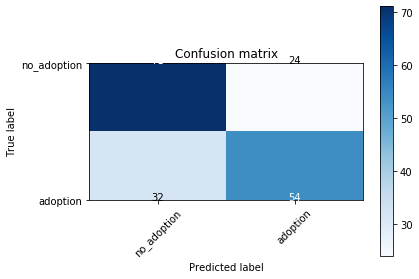

In [28]:
from src.confusion import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, accuracy_score, recall_score, precision_score
plot_confusion_matrix(confusion_matrix(y_val, y_hat_val),classes=['no_adoption', 'adoption'])

In [29]:
print(f'Accuracy Score: {accuracy_score(y_val, y_hat_val)}')
print('-------------------')
print(f'Precision score: {precision_score(y_val, y_hat_val)}')
print('-------------------')
print(f'Recall Score: {recall_score(y_val, y_hat_val)}')
print('-------------------')
print(f'f1_score: {f1_score(y_val, y_hat_val)}')
print('-------------------')
print(f'roc_auc_score{roc_auc_score(y_val, y_hat_val)}')

Accuracy Score: 0.6906077348066298
-------------------
Precision score: 0.6923076923076923
-------------------
Recall Score: 0.627906976744186
-------------------
f1_score: 0.6585365853658537
-------------------
roc_auc_score0.6876376988984089


#### Visualizations

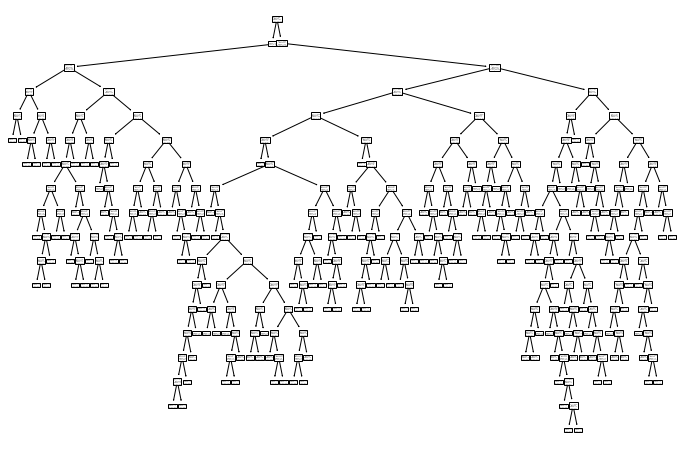

In [30]:
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(12, 8))
plot_tree(dt, ax=ax);

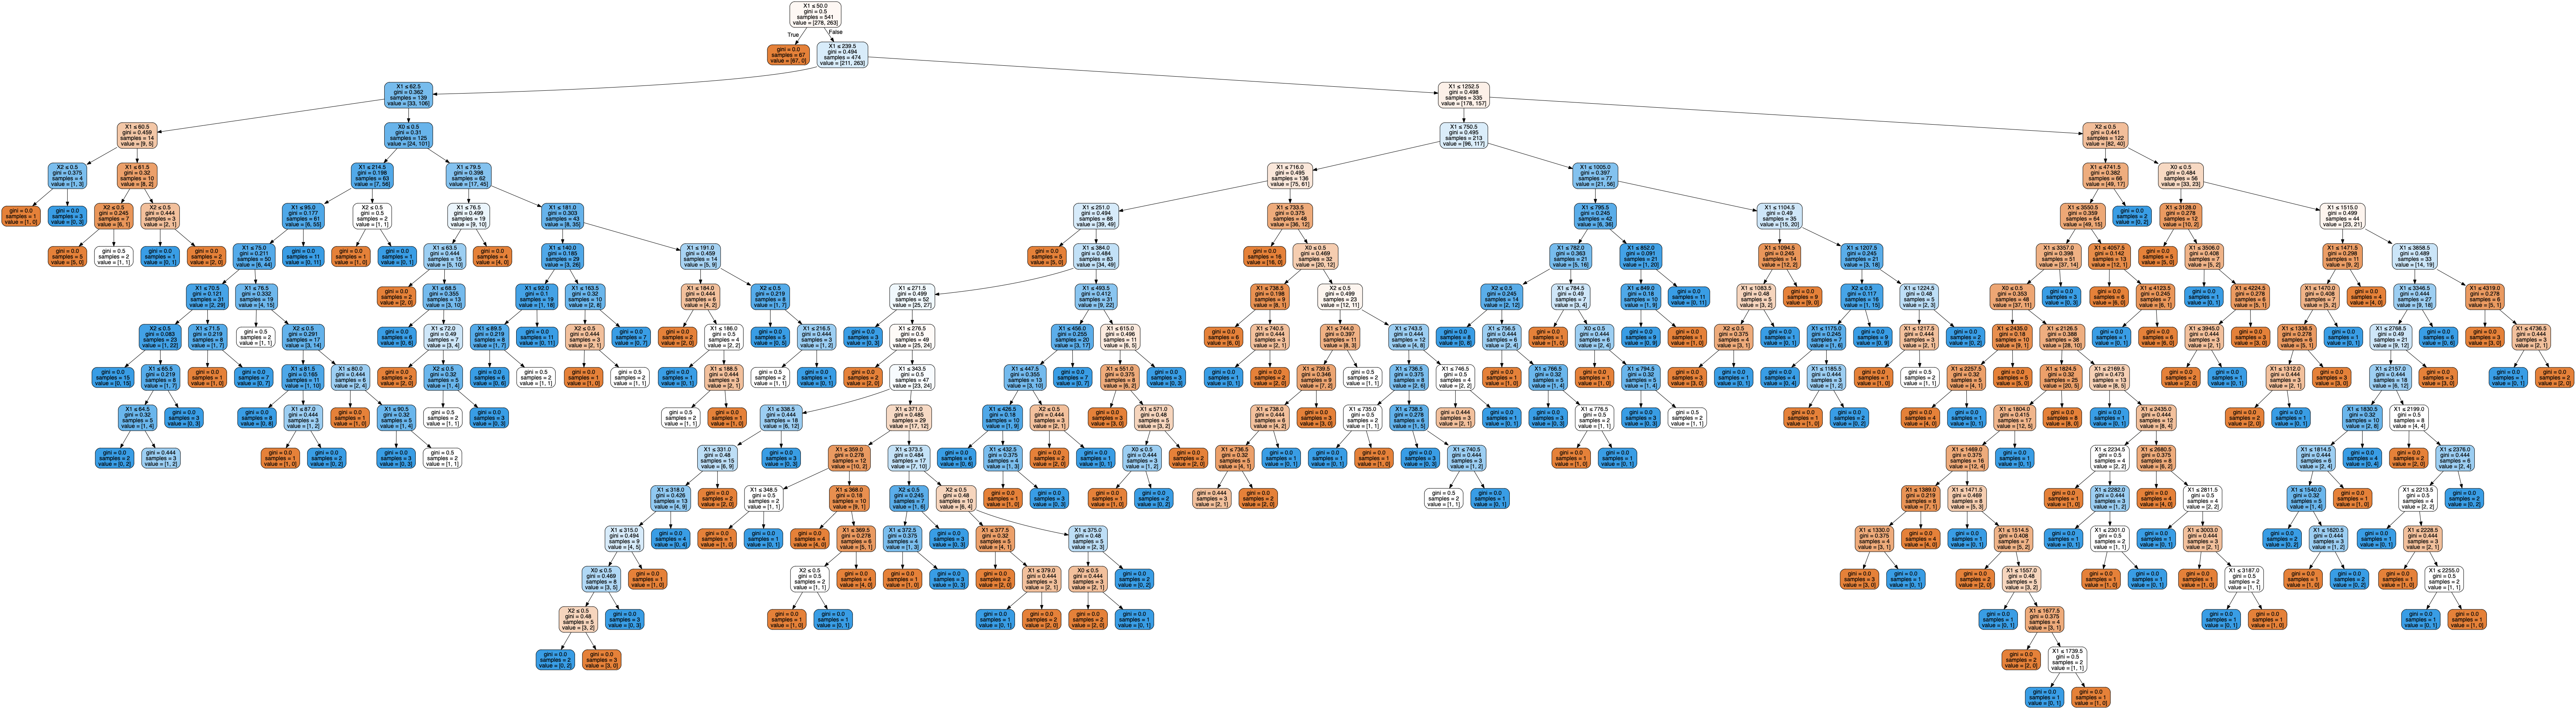

In [31]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## 4. Issues with Decision Trees

### Decision trees are prone to overfitting

The image above is a good visual to represent an overfit tree.  Let's look at the accuracy.

In [32]:
dt.score(X_t,y_t)

0.9722735674676525

That super high accuracy score is a telltale sign of an overfit model. Let's compare it to the validation set:

In [33]:
dt.score(X_val, y_val)

0.6906077348066298

That's a big drop-off!

### Bias-Variance with Decision Trees

The CART algorithm will repeatedly partition data into smaller and smaller subsets until those final subsets are homogeneous in terms of the outcome variable. In practice this often means that the final subsets (known as the leaves of the tree) each consist of only one or a few data points. 

This results in low-bias, high variance trees.


### Stopping Criterion - Pruning Parameters

The recursive binary splitting procedure described above needs to know when to stop splitting as it works its way down the tree with the training data.

**min_samples_leaf:**  The most common stopping procedure is to use a minimum count on the number of training instances assigned to each leaf node. If the count is less than some minimum then the split is not accepted and the node is taken as a final leaf node.

**max_leaf_nodes:** 
Reduce the number of leaf nodes

**max_depth:**
Reduce the depth of the tree to build a generalized tree
Set the depth of the tree to 3, 5, 10 depending after verification on test data

**min_impurity_split :**
A node will split if its impurity is above the threshold, otherwise it is a leaf.

Let's try limiting the depth (by default the limit is `None`, i.e. unlimited depth):

In [34]:
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_t, y_t)
print(dt.score(X_t, y_t))
print(dt.score(X_val, y_val))

0.7486136783733827
0.6685082872928176


In [35]:
dt = DecisionTreeClassifier(max_depth=8)
dt.fit(X_t, y_t)
print(dt.score(X_t, y_t))
print(dt.score(X_val, y_val))

0.8428835489833642
0.7016574585635359


Let's try limiting minimum samples per leaf (by default the limit is 1, i.e. a leaf node can have as few as 1 sample in it):

In [36]:
dt = DecisionTreeClassifier(min_samples_leaf=3)
dt.fit(X_t, y_t)
print(dt.score(X_t, y_t))
print(dt.score(X_val, y_val))

0.866913123844732
0.7182320441988951


In [37]:
dt = DecisionTreeClassifier(min_samples_leaf=5)
dt.fit(X_t, y_t)
print(dt.score(X_t, y_t))
print(dt.score(X_val, y_val))

0.844731977818854
0.7071823204419889


### Decision trees are very sensitive to training data

Let's fit two trees that differ only by 10 samples, and look at the difference.

In [38]:
dt = DecisionTreeClassifier(max_depth=5)
X_t_sample_1 = X_t.sample(100, random_state=1)
y_t_sample_1 = y_t[X_t_sample_1.index]

dt.fit(X_t_sample_1, y_t_sample_1)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

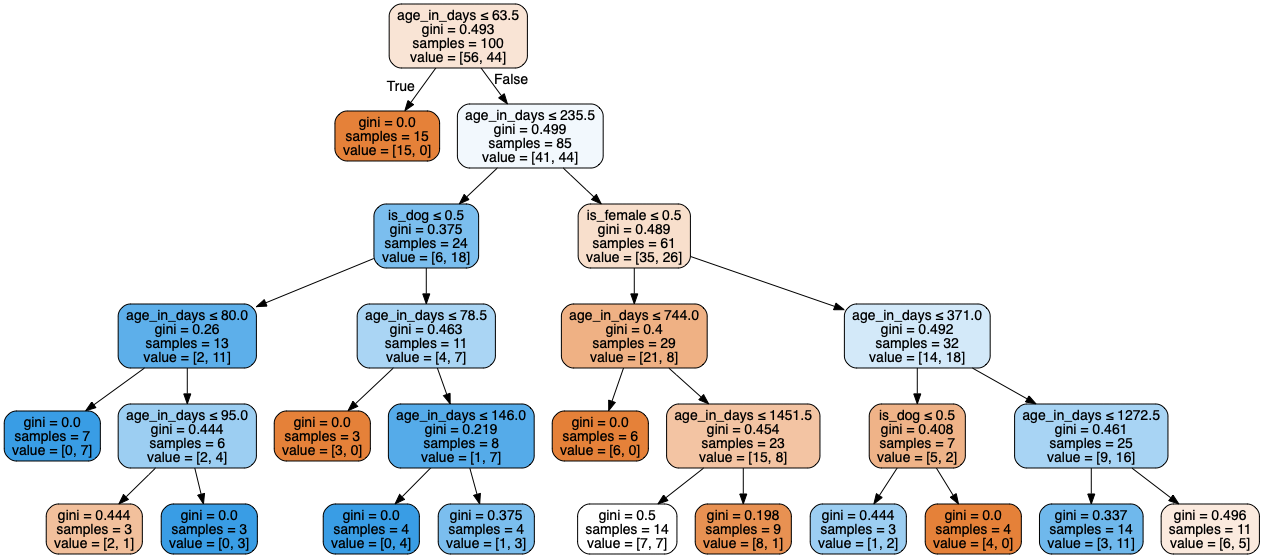

In [39]:
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, 
               feature_names=X_t.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [40]:
dt = DecisionTreeClassifier(max_depth=5)
X_t_sample_2 = X_t_sample_1.sample(90, random_state=42)
y_t_sample_2 = y_t[X_t_sample_2.index]

dt.fit(X_t_sample_2, y_t_sample_2)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

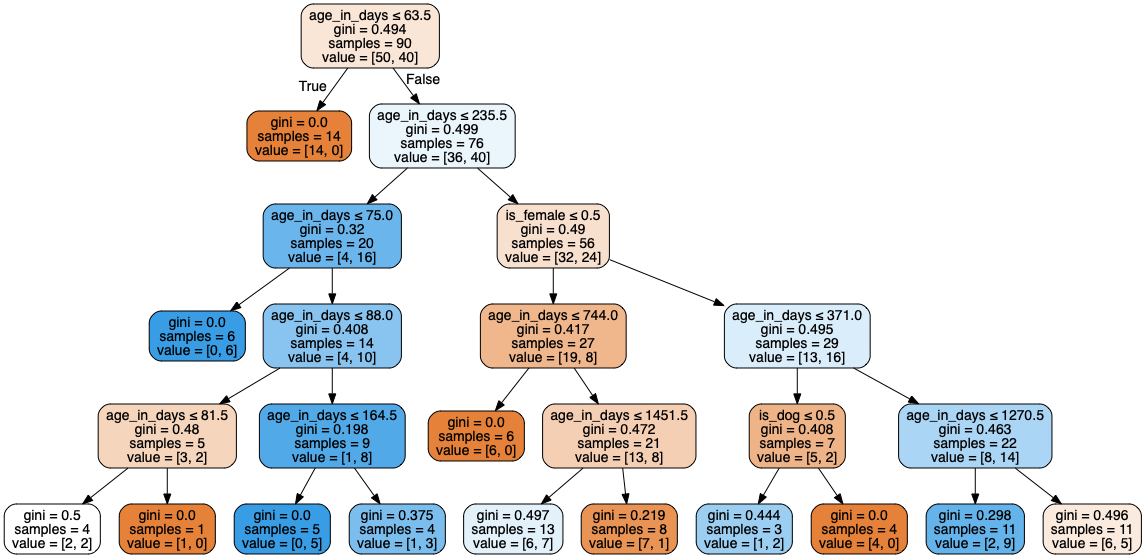

In [41]:
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                   feature_names=X_t.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Greediness

Decision trees will always split on the features with the most advantageous split. 

Take the above example.  The algorithm is almost exclusively using the `age_in_days` feature, potentially obscuring more-valuable information in `is_female` or `is_dog` 

We will see how to overcome greediness with Random Forests.



## 5. Feature Importances

The fitted tree has an attribute called `dt.feature_importances_`. What does this mean? Roughly, the importance (or "Gini importance") of a feature is a sort of weighted average of the impurity decrease at internal nodes that make use of the feature. The weighting comes from the number of samples that depend on the relevant nodes.

> The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance. [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_)

In [42]:
dt = DecisionTreeClassifier(max_depth=8)
dt.fit(X_t, y_t)

for fi, feature in zip(dt.feature_importances_, X_t.columns):
    print(fi, feature)

0.039382498667577016 is_dog
0.9109089927551469 age_in_days
0.049708508577275975 is_female


More on feature importances [here](https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3)

# Conclusions

Decision Tree is a white box type of ML algorithm. It shares internal decision-making logic, which is not available in the black box type of algorithms such as Neural Network. Its training time is faster compared to the neural network algorithm. The decision tree is a non-parametric method, which does not depend upon probability distribution assumptions. Decision trees can handle high dimensional data with good accuracy.

#### Pros
- Decision trees are easy to interpret and visualize.
- It can easily capture non-linear patterns.
- It requires little data preprocessing from the user, for example, there is no need to normalize columns.
- It can be used for feature engineering such as predicting missing values, suitable for variable selection.
- The decision tree has no assumptions about distribution because of the non-parametric nature of the algorithm.

#### Cons
- Sensitive to noisy data. It can overfit noisy data.
- The small variation (or variance) in data can result in the different decision tree. This can be reduced by bagging and boosting algorithms.
- Decision trees are biased with imbalanced datasets, so it is recommended that you balance out the dataset before creating the decision tree.

## 6. Appendix: Grid Search

Because there are multiple techniques for pruning a decision tree, each with their own impacts on bias vs. variance, you'll often want to use a grid search to find the best combination of parameters.  Look in the `solution` branch for a filled-in example

In [43]:
from sklearn.model_selection import GridSearchCV

In [44]:
param_grid = [{
    'criterion': ['gini', 'entropy'],
    'max_leaf_nodes': [5, 10, 20, None],
    'max_depth': [2, 5, 10, None],
    'min_samples_leaf': [2, 5, 15],
    'min_impurity_decrease': [0.001, 0.00001, 0.0000001]
}]

In [45]:
search = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=5)
search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'criterion': ['gini', 'entropy'],
                  

In [46]:
search.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=1e-07, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [47]:
search.best_estimator_.score(X_train, y_train)

0.8462603878116344

In [48]:
search.best_estimator_.score(X_test, y_test)

0.7016574585635359